In [1]:
import pandas as pd
import networkx as nx
from sklearn.cluster import Birch
import numpy as np
from networkx.algorithms.community.centrality import girvan_newman
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans, DBSCAN, Birch
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings('ignore')
import igraph as ig

In [ ]:
#drawing plane for network X: -1 to 1, Y :-1 to 1 

# Functions

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

def find_best_num_clusters(data, max_clusters=10):
    best_score = -1
    best_num_clusters = 2  # Minimum number of clusters
    
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_num_clusters = n_clusters
    
    return best_num_clusters

In [3]:
from sklearn.cluster import AgglomerativeClustering, OPTICS, SpectralClustering


def get_clusters_from_positions(G, posdf, best_num, true_labels):
    #agglomerative clustering
    scores = []
    model = AgglomerativeClustering(affinity='euclidean', n_clusters=best_num)
    model.fit(posdf)
    yhat = list(model.labels_)
    scores.append(adjusted_rand_score(true_labels, yhat))

    #DBscan
    model = OPTICS()
    model.fit(posdf)
    yhat= list(model.labels_)
    scores.append(adjusted_rand_score(true_labels, yhat))

    # kmeans
    model = KMeans(n_clusters=best_num, random_state=212)
    model.fit(posdf)
    yhat = list(model.predict(posdf))
    scores.append(adjusted_rand_score(true_labels, yhat))

    #GMM
    from sklearn.mixture import GaussianMixture
    #modeling
    model = GaussianMixture(n_components=best_num, random_state=212).fit(posdf)
    yhat = list(model.predict(posdf))
    scores.append(adjusted_rand_score(true_labels, yhat))

    #Birch
    model = Birch(n_clusters=best_num)
    model.fit(posdf)
    yhat = list(model.predict(posdf))
    scores.append(adjusted_rand_score(true_labels, yhat))

    communities = girvan_newman(G)

    #community detections

    #Girvan Newman
    communities = girvan_newman(G)
    comms = []
    for com in next(communities):
        comms.append(list(com))
    list_comms = [None] * len(G.nodes)
    for i in range(len(comms)):
        com = comms[i]
        for node in com:
            list_comms[node] = i

    scores.append(adjusted_rand_score(true_labels, list_comms))

    #Leiden
    G_ig = ig.Graph.TupleList(nx.to_edgelist(G), directed=False)
    partition = G_ig.community_leiden(objective_function="modularity")
    list_comms = [None] * len(G.nodes)
    for i, com in enumerate(partition):
        for node in com:
            list_comms[node] = i

    scores.append(adjusted_rand_score(true_labels, list_comms))
    return scores


In [4]:
def add_scores(df, scores, layout_name='spring'):
    scores.insert(0, layout_name)
    data = df.to_dict('records')
    data.append(dict(zip(df.columns, scores)))
    df = pd.DataFrame(data)
    return df


In [5]:
def scaling_igraph(layout):
    coords = np.array(layout.coords)
    min_coords = coords.min(axis=0)
    max_coords = coords.max(axis=0)
    scaled_coords = 2 * (coords - min_coords) / (max_coords - min_coords) - 1
    posdf = pd.DataFrame(scaled_coords, columns=['X', 'Y'])
    return posdf

In [6]:
def full_experiment_on_graph(G, true_labels):
    df = pd.DataFrame(columns=['layout','AgglomerativeClustering', 'OPTICS', 'KMeans', 'GMM', 'Birch', 'Girvan Newman', 'Leiden'])
    
    #for every layout
    #kamada kawai
    pos = nx.kamada_kawai_layout(G)
    posdf = pd.DataFrame.from_dict(pos, orient='index', columns=['X', 'Y'])
    best_num = find_best_num_clusters(posdf)
    scores = get_clusters_from_positions(G,posdf, best_num, true_labels)
    df = add_scores(df, scores, 'kamada_kawai')

    #spring layout
    pos = nx.spring_layout(G)
    posdf = pd.DataFrame.from_dict(pos, orient='index', columns=['X', 'Y'])
    best_num = find_best_num_clusters(posdf)
    scores = get_clusters_from_positions(G,posdf, best_num, true_labels)
    df = add_scores(df, scores, 'spring')

    #algorithms from igraph
    G_ig = ig.Graph.TupleList(nx.to_edgelist(G), directed=False)

    #davidson harel
    layout = G_ig.layout('davidson_harel')
    posdf = scaling_igraph(layout)
    # posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
    best_num = find_best_num_clusters(posdf)
    scores = get_clusters_from_positions(G, posdf, best_num, true_labels)
    df = add_scores(df, scores, 'davidson_harel')

    #drl
    layout = G_ig.layout('drl')
    posdf = scaling_igraph(layout)
    # posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
    best_num = find_best_num_clusters(posdf)
    scores = get_clusters_from_positions(G, posdf, best_num, true_labels)
    df = add_scores(df, scores, 'drl')

    # fruchterman reingold
    layout = G_ig.layout('fruchterman_reingold')
    posdf = scaling_igraph(layout)
    # posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
    best_num = find_best_num_clusters(posdf)
    scores = get_clusters_from_positions(G, posdf, best_num, true_labels)
    df = add_scores(df, scores, 'fruchterman_reingold')

    #graphopt
    layout = G_ig.layout('graphopt')
    posdf = scaling_igraph(layout)
    # posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
    best_num = find_best_num_clusters(posdf)
    scores = get_clusters_from_positions(G, posdf, best_num, true_labels)
    df = add_scores(df, scores, 'graphopt')

    #lgl
    layout = G_ig.layout('lgl')
    posdf = scaling_igraph(layout)
    # posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
    best_num = find_best_num_clusters(posdf)
    scores = get_clusters_from_positions(G,  posdf, best_num, true_labels)
    df = add_scores(df, scores, 'lgl')

    #mds
    layout = G_ig.layout('mds')
    posdf = scaling_igraph(layout)
    # posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
    best_num = find_best_num_clusters(posdf)
    scores = get_clusters_from_positions(G, posdf, best_num, true_labels)
    df = add_scores(df, scores, 'mds')

    return df
            


# Usage

### Generating the graph

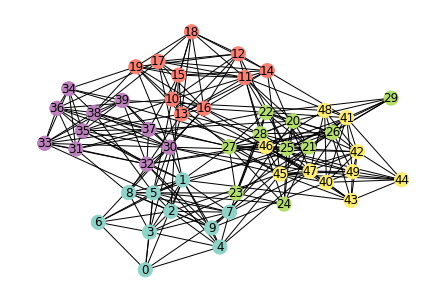

In [53]:
#graph generating
sizes = [10, 10, 10, 10, 10]
# probs = [[0.8, .02, .02, .02], [.02, 0.8, .02, .02], [0.02, 0.02, 0.8, .02], [.02, .02, .02, .8]]
probs = [[.8, .08, .08, .08, .08], [.08, .8, .08, .08, .08], [.08, .08, .8, .08, .08], [.08, .08, .08, .8, .08], [.08, .08, .08, .08, .8]]

true_labels=[]
i=0
for size in sizes:
    true_labels += ([i]*size)
    i += 1
G = nx.stochastic_block_model(sizes, probs, seed=212)
# nx.draw(G, node_size=200)
# plt.figure(figsize=(9,9))
nx.draw(G, node_color=true_labels, cmap=plt.cm.Set3, with_labels=True, node_size=200)
plt.show()

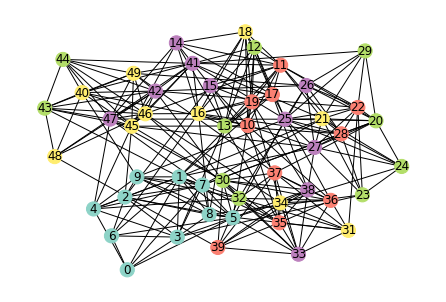

In [54]:
num_communities=5
G_ig = ig.Graph.TupleList(nx.to_edgelist(G), directed=False)
partition = G_ig.community_leiden(objective_function="modularity", resolution= 1)
list_comms = [None] * len(G.nodes)
for i, com in enumerate(partition):
    for node in com:
        list_comms[node] = i
# len(set(list_comms))
nx.draw(G, node_color=list_comms, cmap=plt.cm.Set3, with_labels=True, node_size=200)


In [44]:
print(list_comms)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [37]:
communities=girvan_newman_modified(G, 5)



In [49]:
# communities = girvan_newman(G)
comms = []
for com in communities:
    comms.append(list(com))
# comms
list_comms = [None] * len(G.nodes)
for i in range(len(comms)):
    com = comms[i]
    for node in com:
        list_comms[node] = i

# list_comms

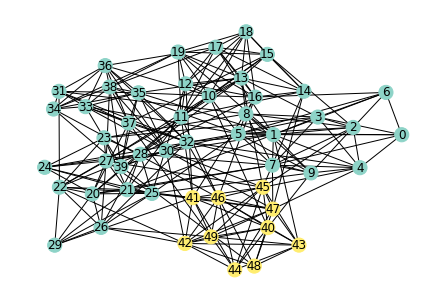

In [18]:
nx.draw(G, node_color=list_comms, cmap=plt.cm.Set3, with_labels=True, node_size=200)


In [52]:
#graph generating
sizes = [10, 10, 10]
probs = [[0.5, 0.05, 0.05], [0.05, 0.5, 0.05], [0.05, 0.05, 0.5]]
true_labels=[]
i=0
for size in sizes:
    true_labels += ([i]*size)
    i += 1
G = nx.stochastic_block_model(sizes, probs, seed=212)
# nx.draw(G, node_size=200)

In [38]:
df = full_experiment_on_graph(G, true_labels)
df

,layout,AgglomerativeClustering,OPTICS,KMeans,GMM,Birch,Girvan Newman,Leiden
0,kamada_kawai,0.808229,0.469237,1.000000,1.000000,0.808229,0.553846,0.484444
1,spring,1.000000,0.710170,0.808229,1.000000,0.637766,0.553846,0.484444
2,davidson_harel,0.506171,0.415820,0.305863,0.449715,0.403254,0.553846,0.484444
3,drl,0.408804,0.014499,0.275533,0.408804,0.408804,0.553846,0.484444
4,fruchterman_reingold,0.484444,0.363318,0.484444,0.484444,0.426539,0.553846,0.484444
5,graphopt,0.488611,0.271013,0.488611,0.488611,0.428861,0.553846,0.484444
6,lgl,0.000000,0.359321,0.000000,0.000000,0.000000,0.553846,0.484444
7,mds,0.512290,0.425515,0.484444,0.484444,0.401680,0.553846,0.484444


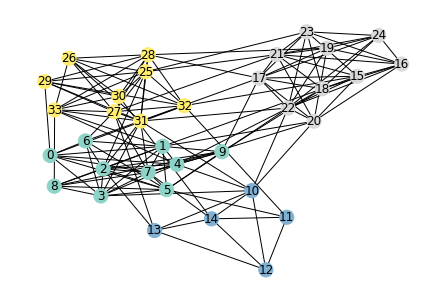

In [46]:
#graph generating
sizes = [10, 5, 10, 9]
probs = [[0.8, .1, .1, .1], [.1, 0.8, .1, .1], [0.1, 0.1, 0.8, .1], [.1, .1, .1, .8]]
true_labels=[]
i=0
for size in sizes:
    true_labels += ([i]*size)
    i += 1
G = nx.stochastic_block_model(sizes, probs, seed=212)
# nx.draw(G, node_size=200)
# plt.figure(figsize=(9,9))
nx.draw(G, node_color=true_labels, cmap=plt.cm.Set3, with_labels=True, node_size=200)
plt.show()

In [47]:
df = full_experiment_on_graph(G, true_labels)
df

,layout,AgglomerativeClustering,OPTICS,KMeans,GMM,Birch,Girvan Newman,Leiden
0,kamada_kawai,0.933063,0.421961,0.873824,0.430202,0.762843,0.200692,0.291471
1,spring,0.933063,0.514706,0.933063,0.452242,0.689921,0.200692,0.291471
2,davidson_harel,0.272059,0.086928,0.272059,0.246145,0.259352,0.200692,0.291471
3,drl,0.086928,0.043791,0.158824,0.116330,0.158824,0.200692,0.291471
4,fruchterman_reingold,0.235004,0.265729,0.235004,0.235004,0.304653,0.200692,0.291471
5,graphopt,0.235004,0.359510,0.291471,0.291471,0.199029,0.200692,0.291471
6,lgl,0.019608,0.010381,0.019608,0.019608,0.019608,0.200692,0.291471
7,mds,0.168067,0.180157,0.168067,0.109779,0.235004,0.200692,0.291471


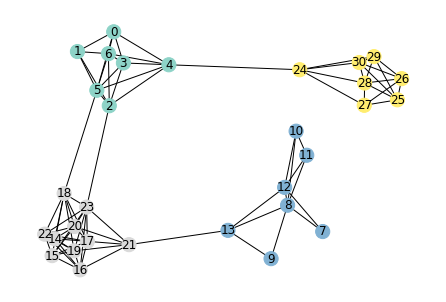

In [50]:
#graph generating
sizes = [7, 7, 10, 7]
probs = [[0.8, .02, .02, .02], [.02, 0.8, .02, .02], [0.02, 0.02, 0.8, .02], [.02, .02, .02, .8]]
true_labels=[]
i=0
for size in sizes:
    true_labels += ([i]*size)
    i += 1
G = nx.stochastic_block_model(sizes, probs, seed=212)
# nx.draw(G, node_size=200)
# plt.figure(figsize=(9,9))
nx.draw(G, node_color=true_labels, cmap=plt.cm.Set3, with_labels=True, node_size=200)
plt.show()

In [51]:
num_communities=5
G_ig = ig.Graph.TupleList(nx.to_edgelist(G), directed=False)
partition = G_ig.community_leiden(objective_function="modularity", resolution= 1)
list_comms = [None] * len(G.nodes)
for i, com in enumerate(partition):
    for node in com:
        list_comms[node] = i
len(set(list_comms))

4

In [8]:
df = full_experiment_on_graph(G, true_labels)
df

,layout,AgglomerativeClustering,OPTICS,KMeans,GMM,Birch,Girvan Newman,Leiden
0,kamada_kawai,1.000000,0.770021,1.000000,1.000000,0.655709,0.292237,0.505524
1,spring,1.000000,0.963104,1.000000,1.000000,0.655709,0.292237,0.505524
2,davidson_harel,0.252396,0.472092,0.252396,0.252396,0.252396,0.292237,0.505524
3,drl,0.505524,0.505524,0.505524,0.505524,0.252396,0.292237,0.505524
4,fruchterman_reingold,0.505524,0.508054,0.505524,0.505524,0.537666,0.292237,0.505524
5,graphopt,0.505524,0.505524,0.505524,0.505524,0.505524,0.292237,0.505524
6,lgl,0.005677,0.471158,0.005677,0.005677,0.005677,0.292237,0.505524
7,mds,0.220871,0.214165,0.220871,0.250549,0.212205,0.292237,0.505524


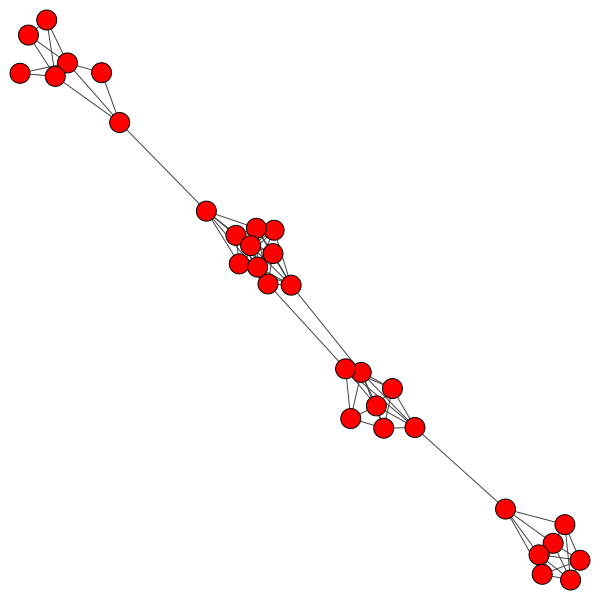

In [9]:
# import pycairo
G_ig = ig.Graph.TupleList(nx.to_edgelist(G), directed=False)
layout = G_ig.layout("fruchterman_reingold")
ig.plot(G_ig, layout=layout)

# TESTS

In [10]:
layout = G_ig.layout('fruchterman_reingold')
posdf = scaling_igraph(layout)
# posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
best_num = find_best_num_clusters(posdf)
scores = get_clusters_from_positions(G, posdf, best_num, true_labels)
df = add_scores(df, scores, 'fruchterman_reingold')

In [11]:
model = AgglomerativeClustering(affinity='euclidean', n_clusters=best_num)
model.fit(posdf)
yhat = list(model.labels_)

### Choosing layout

In [8]:
# layout as input
pos = nx.kamada_kawai_layout(G)
posdf = pd.DataFrame.from_dict(pos, orient='index', columns=['X', 'Y'])
# posar = posdf.values

### Clustering n shit

In [9]:
df = pd.DataFrame(columns=['layout','AgglomerativeClustering', 'OPTICS', 'KMeans', 'GMM', 'Birch', 'Girvan Newman', 'Leiden'])
best_num = find_best_num_clusters(posdf)
scores = get_clusters_from_positions(G, posdf, best_num)
df = add_scores(df, scores, 'kamada_kawai')
df

,layout,AgglomerativeClustering,OPTICS,KMeans,GMM,Birch,Girvan Newman,Leiden
0,kamada_kawai,0.808229,0.469237,0.89817,1.0,0.808229,0.553846,0.484444


In [10]:
pos = nx.spring_layout(G)
posdf = pd.DataFrame.from_dict(pos, orient='index', columns=['X', 'Y'])
scores = get_clusters_from_positions(G, posdf, best_num)
df = add_scores(df, scores, 'spring')
df

,layout,AgglomerativeClustering,OPTICS,KMeans,GMM,Birch,Girvan Newman,Leiden
0,kamada_kawai,0.808229,0.469237,0.89817,1.0,0.808229,0.553846,0.484444
1,spring,1.000000,0.852292,1.00000,1.0,0.898170,0.553846,0.484444


In [11]:
G_ig = ig.Graph.TupleList(nx.to_edgelist(G), directed=False)
layout = G_ig.layout('davidson_harel')
pos = layout.coords
posdf = pd.DataFrame(pos, columns=['X', 'Y'])
scores = get_clusters_from_positions(G, posdf, best_num)
df = add_scores(df, scores, 'davidson_harel')
df

,layout,AgglomerativeClustering,OPTICS,KMeans,GMM,Birch,Girvan Newman,Leiden
0,kamada_kawai,0.808229,0.469237,0.898170,1.000000,0.808229,0.553846,0.484444
1,spring,1.000000,0.852292,1.000000,1.000000,0.898170,0.553846,0.484444
2,davidson_harel,0.288718,0.263541,0.383663,0.383663,0.288718,0.553846,0.484444


In [12]:
G_ig = ig.Graph.TupleList(nx.to_edgelist(G), directed=False)


In [13]:
layout = G_ig.layout('davidson_harel')
posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
scores = get_clusters_from_positions(G, posdf, best_num)
df = add_scores(df, scores, 'davidson_harel')

layout = G_ig.layout('drl')
posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
scores = get_clusters_from_positions(G, posdf, best_num)
df = add_scores(df, scores, 'drl')

layout = G_ig.layout('fruchterman_reingold')
posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
scores = get_clusters_from_positions(G, posdf, best_num)
df = add_scores(df, scores, 'fruchterman_reingold')

layout = G_ig.layout('graphopt')
posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
scores = get_clusters_from_positions(G, posdf, best_num)
df = add_scores(df, scores, 'graphopt')


layout = G_ig.layout('lgl')
posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
scores = get_clusters_from_positions(G, posdf, best_num)
df = add_scores(df, scores, 'lgl')

layout = G_ig.layout('mds')
posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
scores = get_clusters_from_positions(G, posdf, best_num)
df = add_scores(df, scores, 'mds')

# layout = G_ig.layout('mds')
# posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
# scores = get_clusters_from_positions(posdf, best_num)
# df = add_scores(df, scores, 'mds')

# template
# layout = G_ig.layout('')
# posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
# scores = get_clusters_from_positions(posdf, best_num)
# df = add_scores(df, scores, '')


In [18]:
df

,layout,AgglomerativeClustering,OPTICS,KMeans,GMM,Birch,Girvan Newman,Leiden
0,kamada_kawai,0.808229,0.469237,0.898170,1.000000,0.808229,0.553846,0.484444
1,spring,1.000000,0.852292,1.000000,1.000000,0.898170,0.553846,0.484444
3,davidson_harel,0.396834,0.316575,0.447976,0.447976,0.396834,0.553846,0.484444
4,drl,0.109039,0.099502,0.211064,0.052848,0.181140,0.553846,0.484444
5,fruchterman_reingold,0.484444,0.370873,0.484444,0.484444,0.484444,0.553846,0.484444
6,graphopt,0.512290,0.242473,0.484444,0.484444,0.512290,0.553846,0.484444
7,lgl,0.008241,0.168993,0.008241,0.008241,0.008241,0.553846,0.484444
8,mds,0.469414,0.367152,0.484444,0.484444,0.484444,0.553846,0.484444


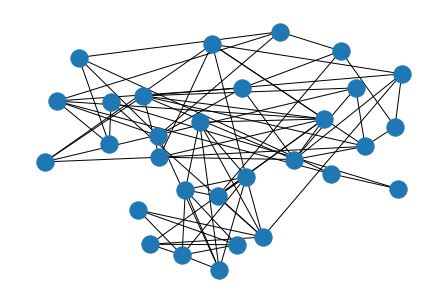

In [21]:
layout = G_ig.layout('drl')
pos = layout.coords
nx.draw(G, pos)

In [20]:
pos

[[0.022727627570555037, -2.2056815932717737],
 [0.08212820994411833, -1.7748328003648184],
 [0.2235294998906484, -1.0189022322666292],
 [-0.3487360535791962, -2.1677642691341323],
 [0.15269057521496796, -1.5545388616417368],
 [0.29889192971932665, -1.1698569297644315],
 [-0.4714354486552614, -0.9765497213790415],
 [-0.21861564814344783, -0.931533490664641],
 [0.01327605617785834, -0.5055680412036212],
 [-0.0256137936114264, -0.8691784696956146],
 [0.9728654819113187, -0.04611316707677416],
 [-1.5258337924576952, -0.44848272627467567],
 [0.30681078661586736, 0.17547931805208183],
 [-0.17459568570611103, 0.55410572837397],
 [1.2068556174122944, -0.14040592396434262],
 [-0.9844301771624644, 0.45303988789055205],
 [0.9583725220342347, 0.7800305007139612],
 [1.403623881418382, 0.7404525155731759],
 [1.2875702299693765, 0.5489703491698672],
 [-0.8165343438096708, 1.0844261175691723],
 [2.294546629375282, 0.2559850757097772],
 [2.0285078630461246, 1.2501629655214694],
 [1.97145586089136, 0.93